# Cognition and Computation Project

## Import Libraries

In [11]:
import math

from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import scipy
import pandas as pd
import numpy as np

## Restricted Boltzmann Machine

In [119]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden, k=1):
        super(RBM, self).__init__()

        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.k = k

    @torch.no_grad()
    def sample_h(self, v):
        prob_h = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return prob_h, torch.bernoulli(prob_h)

    @torch.no_grad()
    def sample_v(self, h):
        prob_v = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return prob_v, torch.bernoulli(prob_v)

    @torch.no_grad()
    def reconstruct(self, v, return_sample=False):
        prob_h, h = self.sample_h(v)
        prob_v_rec, v_rec = self.sample_v(h if return_sample else prob_h)
        return prob_v_rec, v_rec

    def free_energy(self, v):
        vbias_term = v @ self.v_bias
        hidden_term = torch.sum(
            F.softplus(v @ self.W.t() + self.h_bias),
            dim=1
        )
        return -vbias_term - hidden_term

    @torch.no_grad()
    def gibbs_k(self, v):
        prob_h, h = self.sample_h(v)
        prob_v = None
        for _ in range(self.k):
            prob_v, v = self.sample_v(h)
            prob_h, h = self.sample_h(v)
        return prob_v, v

    def fit(self, dataset, learning_rate=0.001, epochs=5, batch_size=32, device=None):
        self.to(device)
        dataset = dataset.to(device)
        n = len(dataset)

        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        recon_loss_history = []
        for epoch in range(epochs):
            epoch_recon_loss_history = []

            shuffle = torch.randperm(n, device=device)

            for start in range(0, n, batch_size):
                i = shuffle[start:start+batch_size]
                v0 = dataset[i]

                prob_v, v = self.gibbs_k(v0)

                loss = (self.free_energy(v0) - self.free_energy(v)).mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                recon_loss = F.mse_loss(v0, prob_v).item()
                epoch_recon_loss_history.append(recon_loss)

            epoch_recon_loss = float(np.mean(epoch_recon_loss_history))
            recon_loss_history.append(epoch_recon_loss)

            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f'Epoch {epoch+1}/{epochs}, MSE: {epoch_recon_loss:.6f}')

        return recon_loss_history

## Deep Belief Network

In [120]:
class DBN(nn.Module):
    def __init__(self, n_visible, n_hidden=[], k=1):
        super(DBN, self).__init__()

        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.k = k

        sizes = [n_visible] + self.n_hidden
        self.rbms = nn.ModuleList([
            RBM(n_visible=sizes[i], n_hidden=sizes[i + 1], k=k)
            for i in range(len(sizes) - 1)
        ])

    @torch.no_grad()
    def encode(self, v, return_samples=False):
        """Forward pass"""
        x = v
        for rbm in self.rbms:
            prob_h, h = rbm.sample_h(x)
            x = h if return_samples else prob_h
        return prob_h, h

    @torch.no_grad()
    def decode(self, h, return_samples=False):
        """Backward (generative) pass"""
        x = h
        for rbm in reversed(self.rbms):
            prob_v, v = rbm.sample_v(x)
            x = v if return_samples else prob_v
        return prob_v, v

    @torch.no_grad()
    def reconstruct(self, v, return_samples=False):
        prob_h, h = self.encode(v, return_samples=return_samples)
        prob_v_rec, v_rec = self.decode(h if return_samples else prob_h, return_samples=return_samples)
        return prob_v_rec, v_rec

    def fit(self, dataset, learning_rate=0.001, epochs=5, batch_size=32, device=None, sample_mode=False):
        x = dataset.to(device)

        histories = []
        for layer_idx, rbm in enumerate(self.rbms):
            print(
                f"Pretraining layer {layer_idx+1}/{len(self.rbms)}: ({rbm.W.shape[1]} -> {rbm.W.shape[0]})"
            )

            hist = rbm.fit(
                dataset=x,
                learning_rate=learning_rate,
                epochs=epochs,
                batch_size=batch_size,
                device=device
            )
            histories.append(hist)

            with torch.no_grad():
                prob_h, h = rbm.sample_h(x)
                x = h if sample_mode else prob_h

        return histories

## Utils functions

In [14]:
def show_img(img, digit=None):
    if digit is not None:
        print(f'The image shows the digit: {digit}')
    img = img.cpu()
    plt.imshow(img, cmap='gray')
    plt.show()


def compare_imgs(imgs, digit):
    print(f'The images show the digit: {digit}')
    n_imgs = len(imgs)
    for i, img in enumerate(imgs):
        img = img.cpu()
        plt.subplot(1, n_imgs, i+1)
        plt.imshow(img, cmap='gray')
    plt.show()

## Training on MNIST

In [121]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

print(f'Using device: {device_name}')

Using device: cuda


In [141]:
mnist_train_ds = torchvision.datasets.MNIST(
    root='mnist', train=True, download=True, transform=torchvision.transforms.ToTensor()
)
mnist_test_ds = torchvision.datasets.MNIST(
    root='mnist', train=False, download=True, transform=torchvision.transforms.ToTensor()
)

mnist_train_ds.data = mnist_train_ds.data / 255
mnist_test_ds.data = mnist_test_ds.data / 255

mnist_train_ds.data = mnist_train_ds.data.to(device)
mnist_test_ds.data = mnist_test_ds.data.to(device)
mnist_train_ds.targets = mnist_train_ds.targets.to(device)
mnist_test_ds.targets = mnist_test_ds.targets.to(device)

mnist_img_shape = (28, 28)
batch_size = 32

mnist_train_loader = DataLoader(
    mnist_train_ds, batch_size=batch_size, shuffle=True
)
mnist_test_loader = DataLoader(
    mnist_test_ds, batch_size=batch_size, shuffle=False
)

The image shows the digit: 5


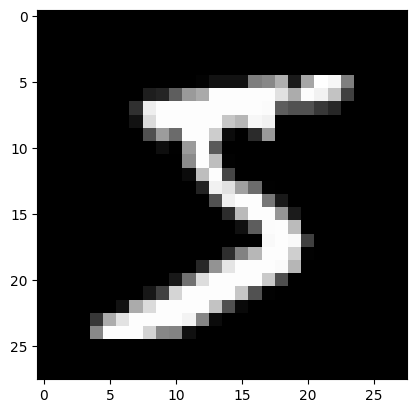

In [123]:
idx = 0
img = mnist_train_ds.data[idx]
digit = mnist_train_ds.targets[idx]

show_img(img, digit)

In [124]:
print(f'Training dataset shape: {mnist_train_ds.data.shape}')
print(f'Test dataset shape: {mnist_test_ds.data.shape}')

Training dataset shape: torch.Size([60000, 28, 28])
Test dataset shape: torch.Size([10000, 28, 28])


In [125]:
# Initialize RBM
n_visible = mnist_img_shape[0] * mnist_img_shape[1]
n_hidden = 128

rbm = RBM(
    n_visible=n_visible,
    n_hidden=n_hidden,
    k=1
)

rbm.to(device)

rbm_weights_file_name = 'rbm_1.pth'

In [126]:
# RBM training
train_ds_size = mnist_train_ds.data.shape[0]
train_data = mnist_train_ds.data.reshape(train_ds_size, n_visible)

loss_history = rbm.fit(
    dataset=train_data,
    learning_rate=0.001,
    epochs=50,
    batch_size=32,
    device=device
)

Epoch 1/50, MSE: 0.045209
Epoch 11/50, MSE: 0.014621
Epoch 21/50, MSE: 0.013137
Epoch 31/50, MSE: 0.012591
Epoch 41/50, MSE: 0.012309
Epoch 50/50, MSE: 0.012140


In [37]:
# Saving RBM weights to file
torch.save(rbm.state_dict(), rbm_weights_file_name)
print(f'RBM model weights saved to "{rbm_weights_file_name}"')

RBM model weights saved to "rbm_1.pth"


In [30]:
# Downloading weights
%%capture
!wget -O {rbm_weights_file_name} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{rbm_weights_file_name}"

In [130]:
# Loading weights from file
rbm.load_state_dict(torch.load(rbm_weights_file_name, map_location=device))
print(f'RBM model weights loaded from "{rbm_weights_file_name}"')

RBM model weights loaded from "rbm_1.pth"


The images show the digit: 0


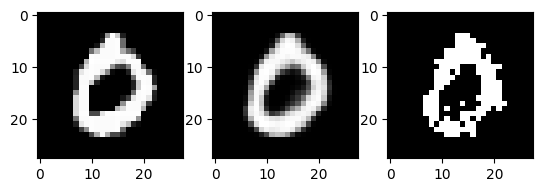

In [131]:
test_idx = 3
test_img = mnist_test_ds.data[test_idx].to(device)
test_digit = mnist_test_ds.targets[test_idx].to(device)

_prob_v, _v = rbm.reconstruct(test_img.reshape(1, n_visible), return_sample=False)
reconstruct_prob_img = _prob_v.reshape(mnist_img_shape).detach()
reconstruct_img = _v.reshape(mnist_img_shape).detach()

compare_imgs([test_img, reconstruct_prob_img, reconstruct_img], test_digit)

In [132]:
# Initialize DBN
dbn = DBN(
    n_visible=n_visible,
    n_hidden=[400, 500, 800],
    k=1
)

dbn.to(device)

dbn_weights_file_name = 'dbn_1.pth'

In [134]:
# DBN training
train_ds_size = mnist_train_ds.data.shape[0]
train_data = mnist_train_ds.data.reshape(train_ds_size, n_visible)

dbn_loss_histories = dbn.fit(
    dataset=train_data,
    learning_rate=0.001,
    epochs=50,
    batch_size=32,
    device=device,
    sample_mode=False,
)

Pretraining layer 1/3: (784 -> 400)
Epoch 1/50, MSE: 0.013549
Epoch 11/50, MSE: 0.009383
Epoch 21/50, MSE: 0.008906
Epoch 31/50, MSE: 0.008691
Epoch 41/50, MSE: 0.008584
Epoch 50/50, MSE: 0.008511
Pretraining layer 2/3: (400 -> 500)
Epoch 1/50, MSE: 0.048329
Epoch 11/50, MSE: 0.010573
Epoch 21/50, MSE: 0.009598
Epoch 31/50, MSE: 0.009324
Epoch 41/50, MSE: 0.009212
Epoch 50/50, MSE: 0.009145
Pretraining layer 3/3: (500 -> 800)
Epoch 1/50, MSE: 0.031163
Epoch 11/50, MSE: 0.006344
Epoch 21/50, MSE: 0.005784
Epoch 31/50, MSE: 0.005578
Epoch 41/50, MSE: 0.005481
Epoch 50/50, MSE: 0.005437


In [46]:
# Saving DBN weights to file
torch.save(dbn.state_dict(), dbn_weights_file_name)
print(f'DBN model weights saved to "{dbn_weights_file_name}"')

DBN model weights saved to "dbn_1.pth"


In [84]:
# Downloading weights
%%capture
!wget -O {dbn_weights_file_name} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{dbn_weights_file_name}"

In [85]:
# Loading weights from file
dbn.load_state_dict(torch.load(dbn_weights_file_name, map_location=device))
print(f'DBN model weights loaded from "{dbn_weights_file_name}"')

DBN model weights loaded from "dbn_1.pth"


The images show the digit: 4


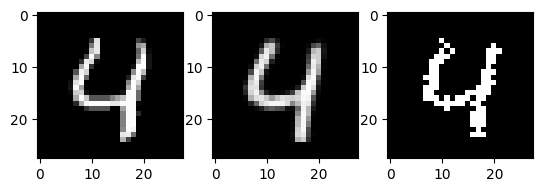

In [135]:
test_idx = 4
test_img = mnist_test_ds.data[test_idx].to(device)
test_digit = mnist_test_ds.targets[test_idx].to(device)

_prob_v, _v = dbn.reconstruct(test_img.reshape(1, n_visible))
reconstruct_prob_img = _prob_v.reshape(mnist_img_shape).detach()
reconstruct_img = _v.reshape(mnist_img_shape).detach()

compare_imgs([test_img, reconstruct_prob_img, reconstruct_img], test_digit)

## Visualizing receptive fields

In [136]:
def get_rbm_weights(rbm):
    return rbm.W.detach().cpu().numpy()


def apply_threshold(weights, threshold):
    return weights * (np.abs(weights) > threshold)


def apply_min_max_scaler(weights):
    shape = weights.shape
    scaler = MinMaxScaler()
    weights = scaler.fit_transform(weights.ravel().reshape(-1, 1))
    weights = weights.reshape(shape)
    return weights


def plot_layer_receptive_fields(weights):
    n_filters = 100
    n_cols = n_rows = int(math.sqrt(n_filters))
    fig, axs = plt.subplots(
        n_rows, n_cols,
        sharex=True, sharey=True, figsize=(15, 15)
    )

    for i in range(n_filters):
        row = i // n_cols
        col = i % n_cols
        axs[row, col].imshow(
            weights[:, i].reshape(mnist_img_shape),
            cmap="gray"
        )
        axs[row, col].axis("off")

    plt.tight_layout()
    display(fig)
    plt.close(fig)

======= Layer 1 =======


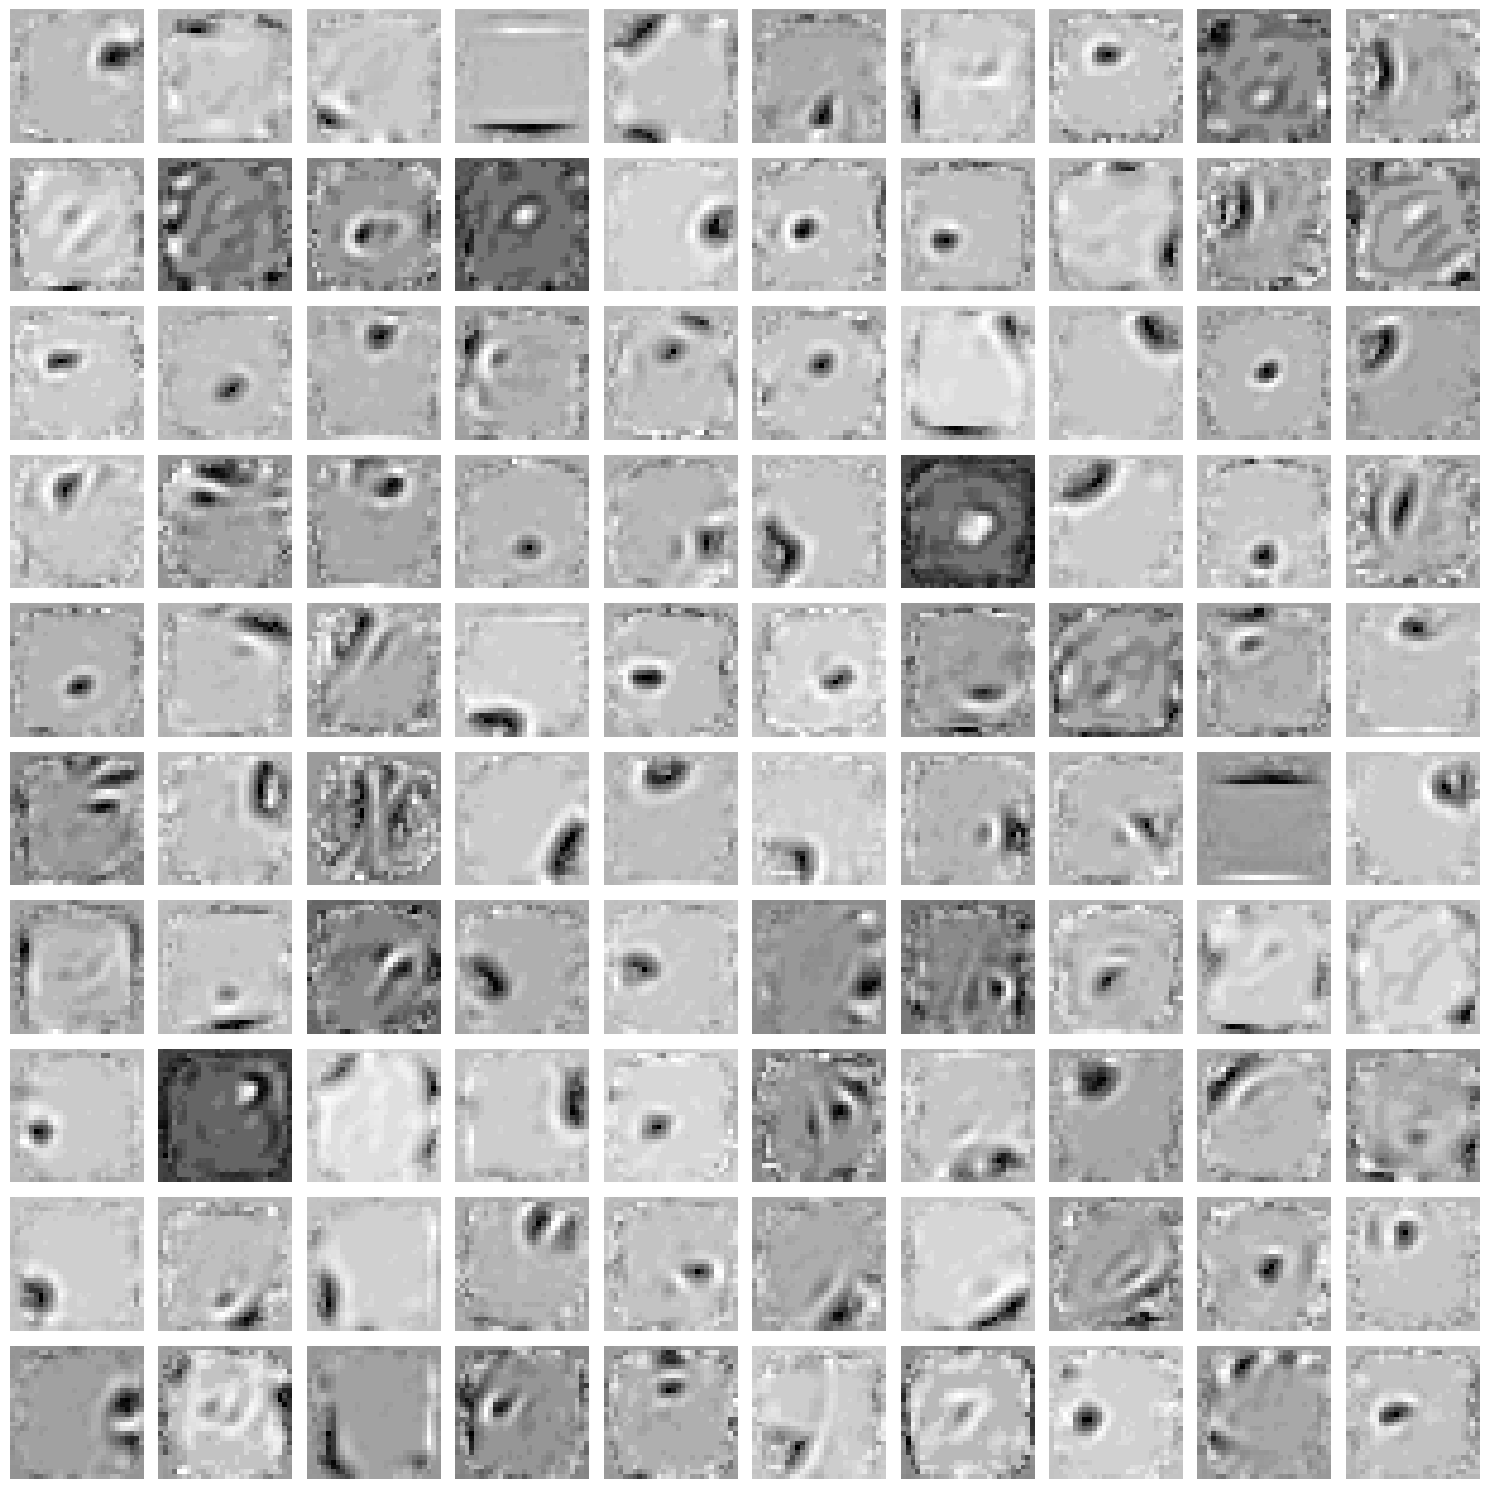


======= Layer 2 =======


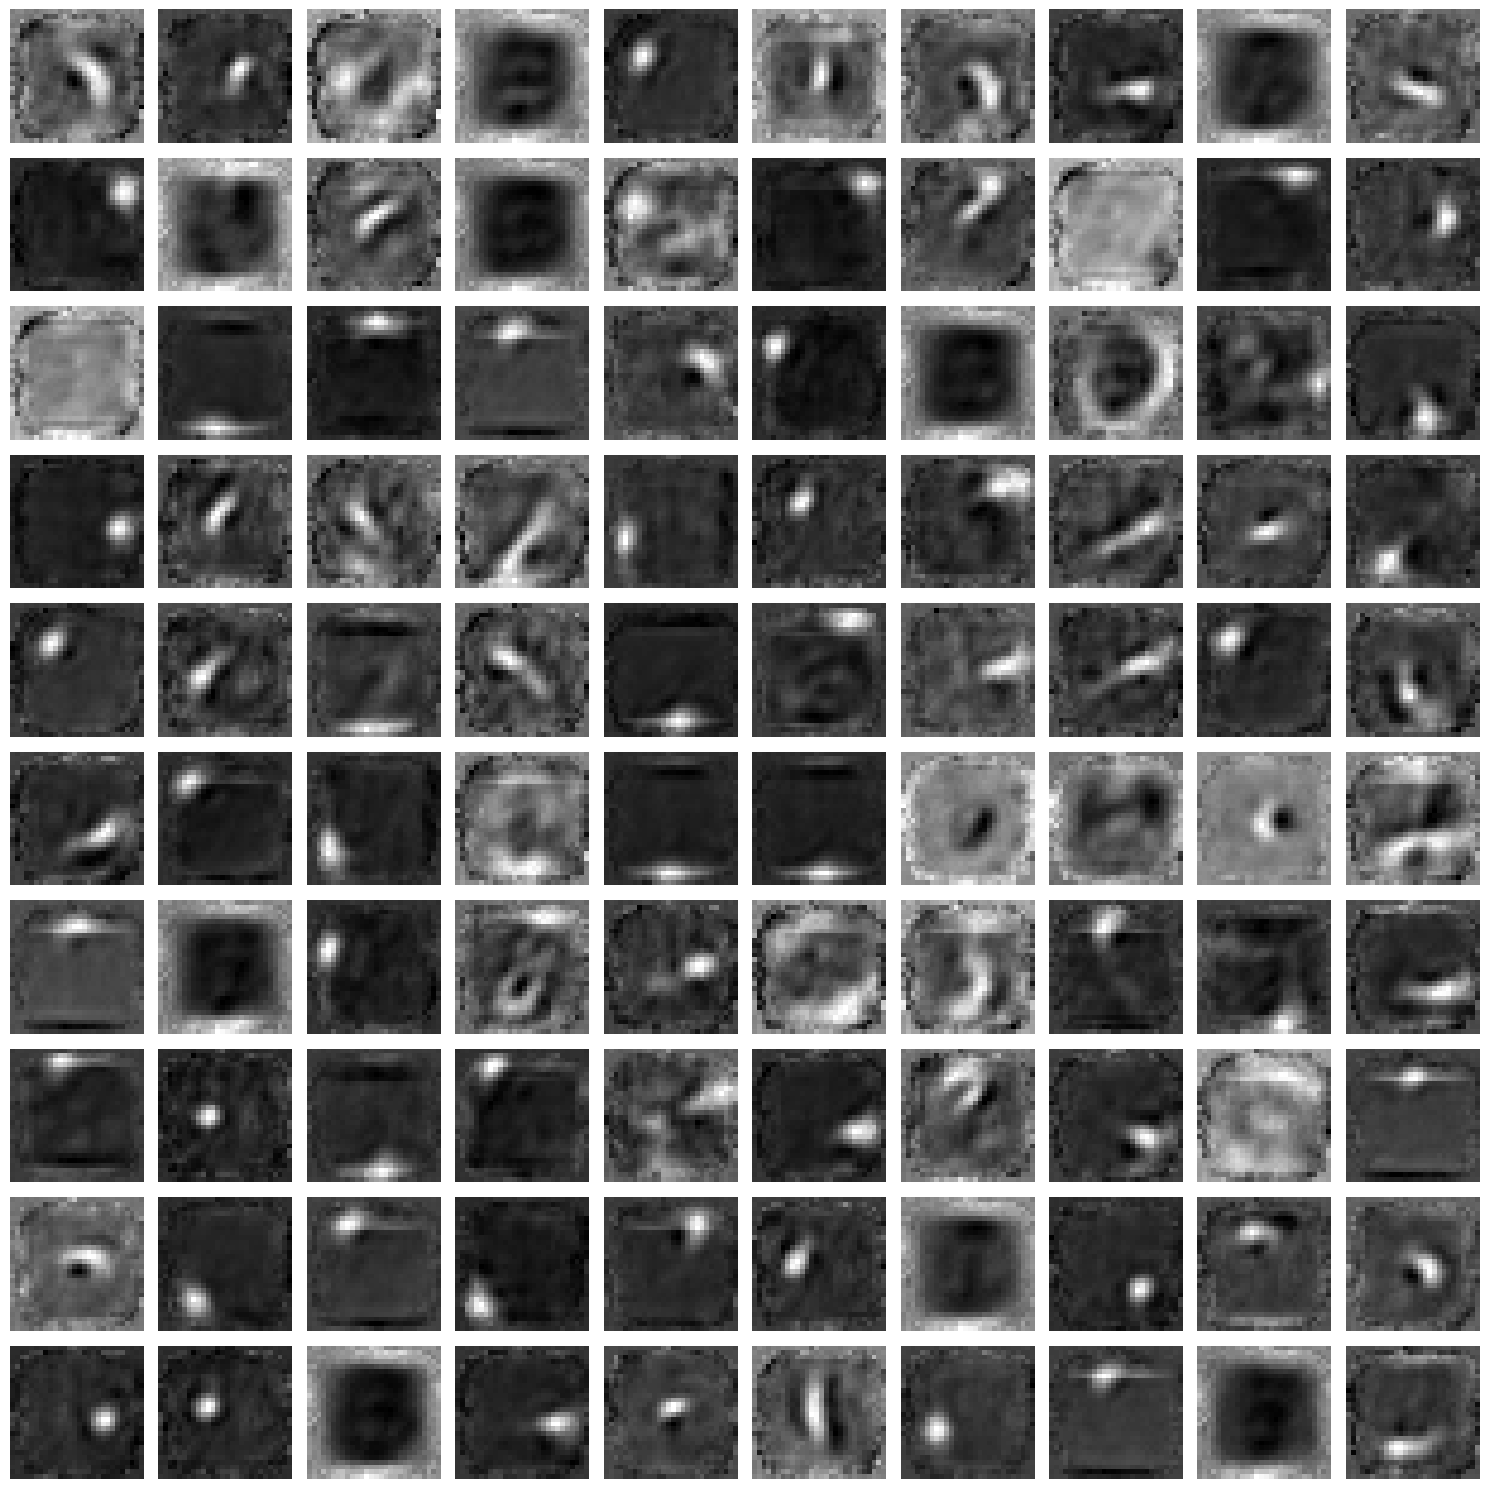


======= Layer 3 =======


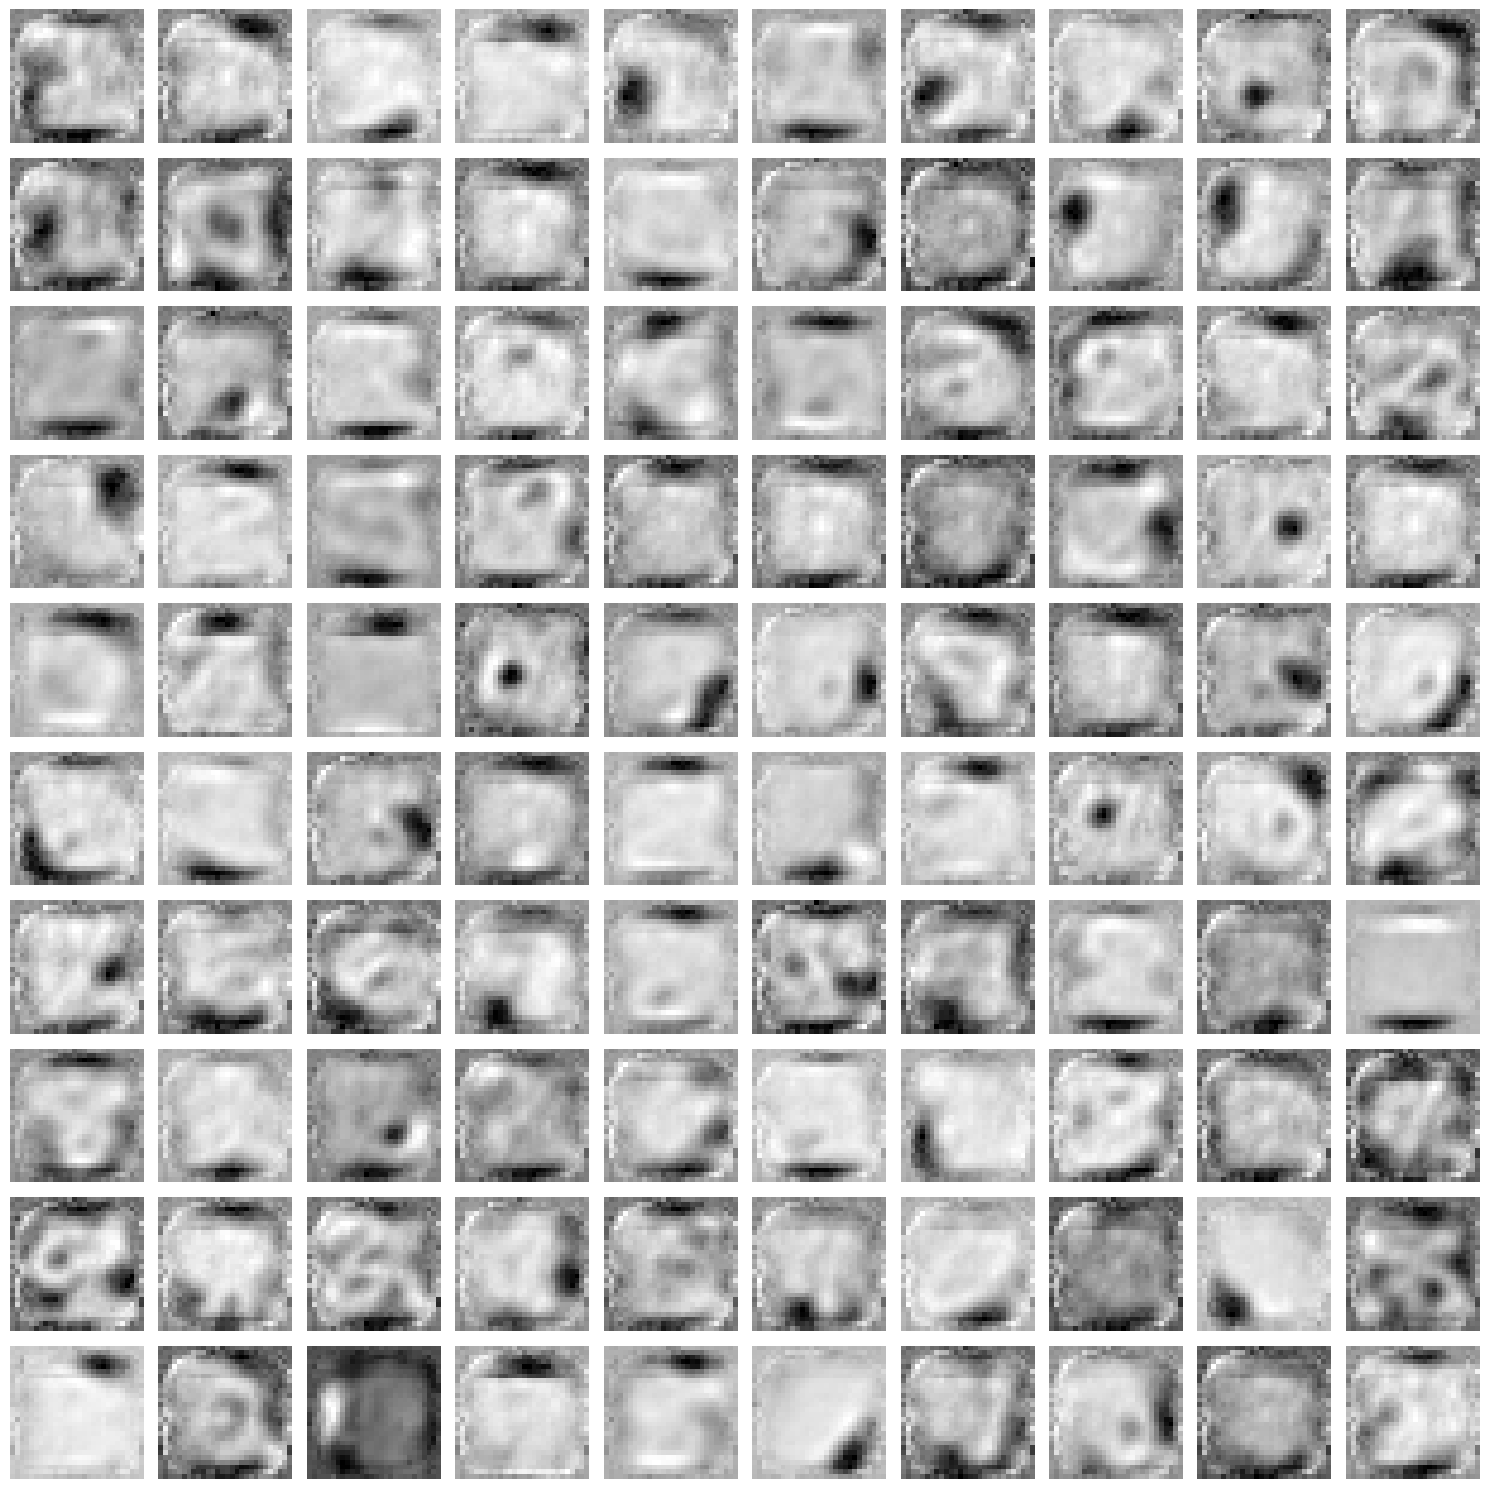

In [137]:
weights_prod = None
for layer_idx, rbm in enumerate(dbn.rbms):
    layer_weights = get_rbm_weights(rbm)
    layer_weights = apply_threshold(layer_weights, 0.1)

    # Linear projection
    weights_prod = (
        weights_prod @ layer_weights.T
    ) if weights_prod is not None else layer_weights.T

    layer_weights = apply_min_max_scaler(weights_prod)

    print(f'======= Layer {layer_idx + 1} =======')
    plot_layer_receptive_fields(layer_weights)
    print()

## Clustering internal representations

In [138]:
def get_label_mask(labels, label):
    return labels == label


def get_mean_representations(representations, labels):
    return {
        label: np.mean(representations[get_label_mask(labels, label)], axis=0)
        for label in np.unique(labels)
    }


def show_dendrogram(representations, labels):
    mean_representations = get_mean_representations(representations, labels)
    representations_matrix = np.concatenate([
        np.expand_dims(mean_representations[label], axis=0)
        for label in np.unique(labels)
    ])

    fig, ax = plt.subplots()
    linkage = scipy.cluster.hierarchy.linkage(
        representations_matrix, method='complete'
    )
    dendrogram = scipy.cluster.hierarchy.dendrogram(linkage)

    plt.tight_layout()
    display(fig)
    plt.close(fig)


def show_clusters(representations, labels):
    mean_representations = get_mean_representations(representations, labels)
    unique_labels = sorted(mean_representations.keys())
    representations_matrix = np.concatenate([
        np.expand_dims(mean_representations[label], axis=0)
        for label in unique_labels
    ])

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(representations_matrix)

    fig, ax = plt.subplots()
    plt.scatter(pca_result[:, 0], pca_result[:, 1])

    for i, label in enumerate(unique_labels):
        plt.annotate(str(label), (pca_result[i, 0], pca_result[i, 1]))

    plt.tight_layout()
    display(fig)
    plt.close(fig)

======= Layer 1 =======


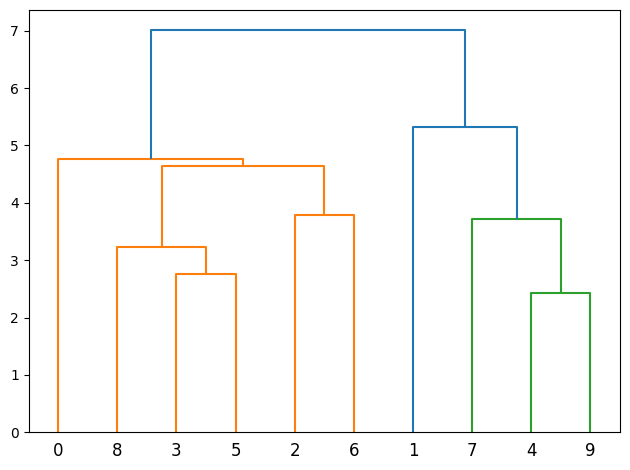

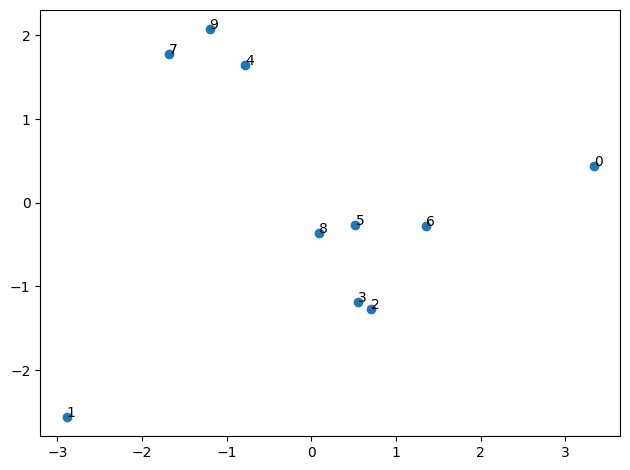


======= Layer 2 =======


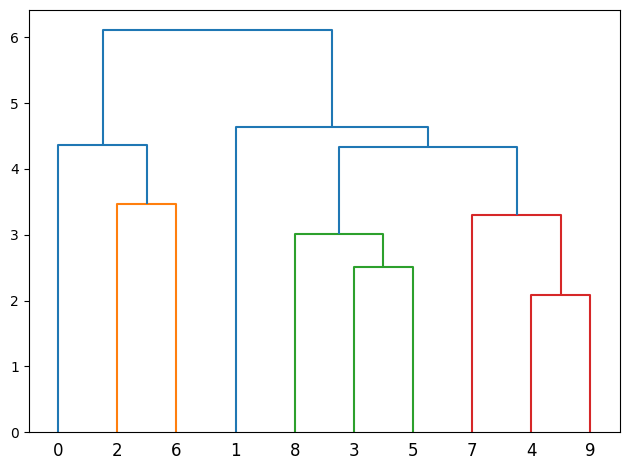

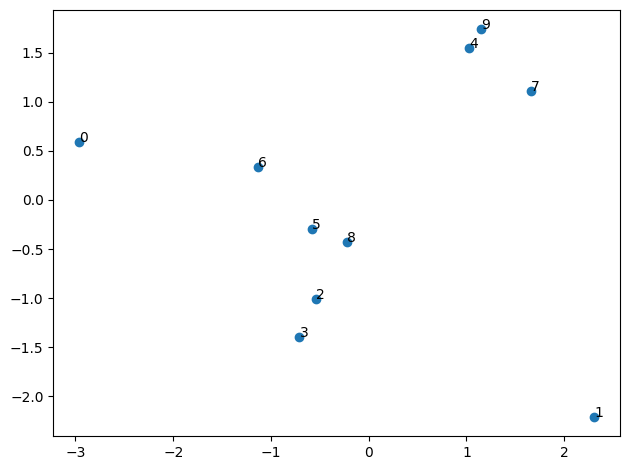


======= Layer 3 =======


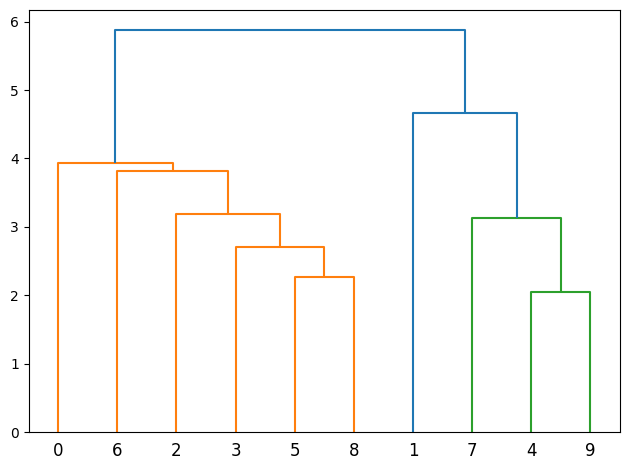

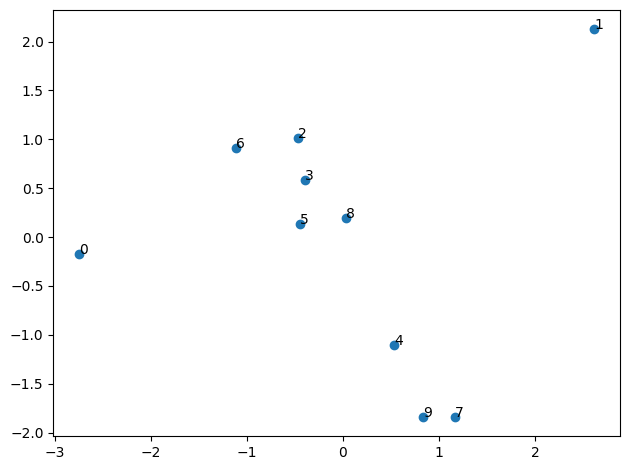

In [145]:
n = len(mnist_test_ds.data)
labels = mnist_test_ds.targets.cpu().numpy()

prob_h = mnist_test_ds.data.reshape(n, n_visible)
for layer_idx, rbm in enumerate(dbn.rbms):
    prob_h, h = rbm.sample_h(prob_h)

    print(f'======= Layer {layer_idx + 1} =======')
    show_dendrogram(prob_h.cpu().numpy(), labels)
    show_clusters(prob_h.cpu().numpy(), labels)
    print()

## Linear read-out layer

In [146]:
class LinearReadOutLayer(nn.Module):
  def __init__(self, n_input, n_output=10) -> None:
      super(LinearReadOutLayer, self).__init__()

      self.linear = nn.Linear(n_input, n_output)

  def forward(self, x):
    return self.linear(x)

In [147]:
linear_layers = []

for layer_idx, rbm in enumerate(dbn.rbms):
    n_input = rbm.W.shape[0]
    linear_layer = LinearReadOutLayer(n_input)
    linear_layer.to(device)

    linear_layers.append({
        'rbm': rbm,
        'linear_layer': linear_layer,
        'filename': f'linear_layer_{layer_idx+1}.pth'
    })

In [148]:
epochs = 1000

n = len(mnist_train_ds.data)
labels = mnist_train_ds.targets

prob_h = mnist_train_ds.data.reshape(n, n_visible)
for layer_idx, linear_layer_dict in enumerate(linear_layers):

    print(f'======= Layer {layer_idx + 1} =======')

    linear_layer = linear_layer_dict['linear_layer']
    rbm = linear_layer_dict['rbm']
    filename = linear_layer_dict['filename']

    prob_h, h = rbm.sample_h(prob_h)

    optimizer = torch.optim.Adam(linear_layer.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = linear_layer(prob_h)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    torch.save(linear_layer.state_dict(), filename)

======= Layer 1 =======
Epoch 1/1000, Loss: 2.4036
Epoch 101/1000, Loss: 0.6084
Epoch 201/1000, Loss: 0.3796
Epoch 301/1000, Loss: 0.2953
Epoch 401/1000, Loss: 0.2497
Epoch 501/1000, Loss: 0.2204
Epoch 601/1000, Loss: 0.1996
Epoch 701/1000, Loss: 0.1838
Epoch 801/1000, Loss: 0.1712
Epoch 901/1000, Loss: 0.1610
Epoch 1000/1000, Loss: 0.1525
======= Layer 2 =======
Epoch 1/1000, Loss: 2.3375
Epoch 101/1000, Loss: 0.6457
Epoch 201/1000, Loss: 0.3878
Epoch 301/1000, Loss: 0.2945
Epoch 401/1000, Loss: 0.2453
Epoch 501/1000, Loss: 0.2143
Epoch 601/1000, Loss: 0.1925
Epoch 701/1000, Loss: 0.1761
Epoch 801/1000, Loss: 0.1632
Epoch 901/1000, Loss: 0.1528
Epoch 1000/1000, Loss: 0.1441
======= Layer 3 =======
Epoch 1/1000, Loss: 2.3401
Epoch 101/1000, Loss: 0.6221
Epoch 201/1000, Loss: 0.3501
Epoch 301/1000, Loss: 0.2575
Epoch 401/1000, Loss: 0.2106
Epoch 501/1000, Loss: 0.1819
Epoch 601/1000, Loss: 0.1622
Epoch 701/1000, Loss: 0.1476
Epoch 801/1000, Loss: 0.1363
Epoch 901/1000, Loss: 0.1273
Epoc

In [ ]:
# Downloading and loading weights from file
%%capture
_loaded_linear_layers = []
for linear_layer_dict in linear_layers:
    linear_layer = linear_layer_dict['linear_layer']
    filename = linear_layer_dict['filename']

    !wget -O {dbn_weights_file_name} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{filename}"

    linear_layer.load_state_dict(torch.load(filename, map_location=device))
    linear_layer.to(device)

    linear_layer_dict['linear_layer'] = linear_layer
    _loaded_linear_layers.append(linear_layer_dict)

linear_layers = _loaded_linear_layers

In [149]:
n = len(mnist_test_ds.data)
labels = mnist_test_ds.targets

prob_h = mnist_test_ds.data.reshape(n, n_visible)
for layer_idx, linear_layer_dict in enumerate(linear_layers):
    linear_layer = linear_layer_dict['linear_layer']
    rbm = linear_layer_dict['rbm']

    prob_h, h = rbm.sample_h(prob_h)

    outputs = linear_layer(prob_h)
    predictions = torch.argmax(outputs, dim=1)

    accuracy = (predictions == labels).sum().item() / len(labels)

    print(f'Layer {layer_idx + 1}: accuracy = {accuracy}')

Layer 1: accuracy = 0.9583
Layer 2: accuracy = 0.9632
Layer 3: accuracy = 0.9674


## Feed-Forward Network / Convolutional Neural Network

In [ ]:
class FFN(nn.Module):
    def __init__(self, img_shape=mnist_img_shape, n_classes=10) -> None:
        super(FFN, self).__init__()

        n_input = img_shape[0] * img_shape[1]
        self.fc1 = nn.Linear(n_input, 400)
        self.fc2 = nn.Linear(400, 500)
        self.fc3 = nn.Linear(500, 800)
        self.fc4 = nn.Linear(800, n_classes)

    def forward(self, x):
        x = x.flatten(1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = self.fc4(x)

        return output

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()

        self.conv_1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same')
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same')
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(3136, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.max_pool_1(x)

        x = self.conv_2(x)
        x = F.relu(x)
        x = self.max_pool_2(x)

        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        output = self.fc2(x)

        return output

In [ ]:
ffn_model = FFN()

ffn_model.to(device)

test_idx = 5
test_batch = next(iter(mnist_test_loader))
test_img, test_digit = test_batch[0][test_idx], test_batch[1][test_idx]

# Creating batch
test_img = test_img.unsqueeze(0)

ffn_model(test_img)
ffn_model(test_batch[0])

summary(ffn_model, mnist_img_shape)

In [ ]:
cnn_model = CNN()

cnn_model.to(device)

test_idx = 5
test_batch = next(iter(mnist_test_loader))
test_img, test_digit = test_batch[0][test_idx], test_batch[1][test_idx]

# Creating batch
test_img = test_img.unsqueeze(0)

cnn_model(test_img)
cnn_model(test_batch[0])

summary(cnn_model, (1, mnist_img_shape[0], mnist_img_shape[1]))

## Robustness to noise

## Adversarial attacks